In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import time
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold


In [ ]:
df = pd.read_pickle(r'./.cleaned_data/electric_screwdriver_dataset_final.pkl')

In [3]:
X_acc = torch.tensor(np.array(df['X_acc'].tolist()), dtype=torch.float32)
X_gyr = torch.tensor(np.array(df['X_gyr'].tolist()), dtype=torch.float32)
X_mag = torch.tensor(np.array(df['X_mag'].tolist()), dtype=torch.float32)
X_mic = torch.tensor(np.array(df['X_mic'].tolist()), dtype=torch.float32)


In [4]:
# verify the output type and shape eg. torch.size([7187, 41, 3])
X_gyr.shape, X_acc.shape, X_mag.shape, X_mic.shape

(torch.Size([7187, 41, 3]),
 torch.Size([7187, 41, 3]),
 torch.Size([7187, 62, 3]),
 torch.Size([7187, 3200, 1]))

## Model Architecture

In [12]:
class SensorTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(SensorTransformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):  # x: [B, T, F]
        x = self.input_proj(x)                  # -> [B, T, d_model]
        x = self.transformer(x)                 # -> [B, T, d_model]
        x = x.permute(0, 2, 1)                  # -> [B, d_model, T]
        x = self.global_pool(x).squeeze(-1)     # -> [B, d_model]
        return x

class JointATTransformer(nn.Module):
    def __init__(self, num_classes=8):
        super(JointATTransformer, self).__init__()
        self.acc_enc = SensorTransformer(input_dim=3)    # Assuming acc has 3 channels
        self.gyr_enc = SensorTransformer(input_dim=3)
        self.mag_enc = SensorTransformer(input_dim=3)
        # self.mic_enc = SensorTransformer(input_dim=1)   # Example: 1 Mel features or similar

        self.fc = nn.Sequential(
            nn.Linear(3 * 64, 128), # update this if adding mic back, 3->4
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x_acc, x_gyr, x_mag):
        f_acc = self.acc_enc(x_acc)
        f_gyr = self.gyr_enc(x_gyr)
        f_mag = self.mag_enc(x_mag)
        # f_mic = self.mic_enc(x_mic)

        fused = torch.cat([f_acc, f_gyr, f_mag], dim=1)
        out = self.fc(fused)
        return out, fused  # Return logits and optional embeddings

# Focal Loss for imbalanced data
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # tensor of shape [num_classes]
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probs = torch.sigmoid(inputs)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_term = (1 - pt) ** self.gamma

        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            focal_term = alpha_t * focal_term

        loss = focal_term * BCE_loss
        return loss.mean() if self.reduction == 'mean' else loss

## Cross-Attention

In [16]:
class SensorTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(SensorTransformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Remove global pooling here, output full sequence
        # self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):  # x: [B, T, F]
        x = self.input_proj(x)                  # -> [B, T, d_model]
        x = self.transformer(x)                 # -> [B, T, d_model]
        return x                              # return sequence


class JointCrossAttentionTransformer(nn.Module):
    def __init__(self, num_classes=8, d_model=64, nhead=4):
        super(JointCrossAttentionTransformer, self).__init__()
        self.acc_enc = SensorTransformer(input_dim=3, d_model=d_model, nhead=nhead)
        self.gyr_enc = SensorTransformer(input_dim=3, d_model=d_model, nhead=nhead)
        self.mag_enc = SensorTransformer(input_dim=3, d_model=d_model, nhead=nhead)
        # self.mic_enc = SensorTransformer(input_dim=1, d_model=d_model, nhead=nhead) # optional mic

        # Cross-attention layers
        self.cross_att_acc = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        self.cross_att_gyr = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        self.cross_att_mag = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        # self.cross_att_mic = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)

        # Final classifier
        self.fc = nn.Sequential(
            nn.Linear(3 * d_model, 128),  # adjust to 4*d_model if mic is added
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x_acc, x_gyr, x_mag):
        # Extract sequences from each sensor
        acc_seq = self.acc_enc(x_acc)  # [B, T, d_model]
        gyr_seq = self.gyr_enc(x_gyr)
        mag_seq = self.mag_enc(x_mag)
        # mic_seq = self.mic_enc(x_mic)

        # Cross-attention: attend acc to mag, gyr to acc, mag to gyr (example)
        # Query, Key, Value format: Q attends to K/V
        acc_attended, _ = self.cross_att_acc(query=acc_seq, key=mag_seq, value=mag_seq)  # acc queries mag
        gyr_attended, _ = self.cross_att_gyr(query=gyr_seq, key=acc_seq, value=acc_seq)  # gyr queries acc
        mag_attended, _ = self.cross_att_mag(query=mag_seq, key=gyr_seq, value=gyr_seq)  # mag queries gyr
        # mic_attended, _ = self.cross_att_mic(query=mic_seq, key=..., value=...)

        # Pool cross-attended sequences (average pooling)
        f_acc = acc_attended.mean(dim=1)  # [B, d_model]
        f_gyr = gyr_attended.mean(dim=1)
        f_mag = mag_attended.mean(dim=1)
        # f_mic = mic_attended.mean(dim=1)

        # Concatenate all features
        fused = torch.cat([f_acc, f_gyr, f_mag], dim=1)  # [B, 3 * d_model]

        # Classify
        out = self.fc(fused)
        return out, fused


## Parameters Configurations

In [ ]:
# --- Parameters ---
os.chdir(r"../models") # can remove this line, I have created a folder for models to save the model
num_epochs = 100
batch_size = 32
patience = 10  # for early stopping
validation_split = 0.2

# --- Dataset ---
y_one_hot = torch.tensor(df["y"].tolist(), dtype=torch.float32)
dataset = TensorDataset(X_acc, X_gyr, X_mag, y_one_hot)
val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)

## Training Process

In [18]:

# Calculate class weights for BCEWithLogitsLoss
# class_counts = torch.tensor([834, 348, 303, 135, 74, 88, 5393, 12], dtype=torch.float32)
# total_samples = class_counts.sum()
# neg_counts = total_samples - class_counts
# pos_weight = neg_counts / class_counts
# pos_weight = pos_weight / pos_weight.mean()
# print("pos_weight:", pos_weight)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))  # Use pos_weight for class imbalance


# --- Model, loss, optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = JointATLSTM(num_classes=8).to(device)
# model = JointATTransformer(num_classes=8).to(device)
model = JointCrossAttentionTransformer(num_classes=8, d_model=64, nhead=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Focal Loss with alpha (inverse frequency normalization)
# Compute alpha (inverse frequency normalized)
class_counts = torch.tensor([834, 348, 303, 135, 74, 88, 5393, 12], dtype=torch.float32)
alpha = (1.0 / class_counts)
alpha = alpha / alpha.sum()  # normalize to sum to 1
alpha = alpha.to(device)

# Instantiate Focal Loss
criterion = FocalLoss(gamma=2.0, alpha=alpha)


# --- Accuracy Function ---
def compute_accuracy(outputs, labels, threshold=0.5):
    preds = (torch.sigmoid(outputs) >= threshold).float()
    correct = (preds == labels).float().sum()
    total = torch.numel(preds)
    return correct / total

# --- Early Stopping ---
best_val_loss = float('inf')
wait = 0
best_model_path = "best_model_checkpoint_with_class_wt_focal_loss_trans_cross_att.pth"

print(f"Training on {device}...\n")

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0
    train_correct = 0.0
    train_total = 0.0

    for batch in train_loader:
        x_acc, x_gyr, x_mag, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs, _ = model(x_acc, x_gyr, x_mag)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_acc.size(0)
        train_correct += compute_accuracy(outputs, labels).item() * labels.numel()
        train_total += labels.numel()

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / train_total

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0.0
    val_total = 0.0

    with torch.no_grad():
        for batch in val_loader:
            x_acc, x_gyr, x_mag, labels = [b.to(device) for b in batch]
            outputs, _ = model(x_acc, x_gyr, x_mag)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * x_acc.size(0)
            val_correct += compute_accuracy(outputs, labels).item() * labels.numel()
            val_total += labels.numel()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / val_total

    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.5f} - Val Loss: {val_loss:.5f} - "
          f"Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f} - Time: {elapsed:.2f}s")

    # --- Checkpoint ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": epoch + 1,
            "loss": val_loss
        }, best_model_path)
        print("✔️  Saved new best model.")
    else:
        wait += 1
        if wait >= patience:
            print("⏹️  Early stopping triggered.")
            break

print("\n Training complete.")


Training on cuda...

Epoch 1/100 - Train Loss: 0.01527 - Val Loss: 0.00333 - Train Acc: 0.8691 - Val Acc: 0.8750 - Time: 9.79s
✔️  Saved new best model.
Epoch 2/100 - Train Loss: 0.00316 - Val Loss: 0.00308 - Train Acc: 0.8750 - Val Acc: 0.8750 - Time: 7.14s
✔️  Saved new best model.
Epoch 3/100 - Train Loss: 0.00278 - Val Loss: 0.00281 - Train Acc: 0.8752 - Val Acc: 0.8754 - Time: 7.15s
✔️  Saved new best model.
Epoch 4/100 - Train Loss: 0.00256 - Val Loss: 0.00255 - Train Acc: 0.8756 - Val Acc: 0.8765 - Time: 7.01s
✔️  Saved new best model.
Epoch 5/100 - Train Loss: 0.00239 - Val Loss: 0.00224 - Train Acc: 0.8760 - Val Acc: 0.8765 - Time: 7.16s
✔️  Saved new best model.
Epoch 6/100 - Train Loss: 0.00217 - Val Loss: 0.00213 - Train Acc: 0.8761 - Val Acc: 0.8766 - Time: 7.72s
✔️  Saved new best model.
Epoch 7/100 - Train Loss: 0.00195 - Val Loss: 0.00193 - Train Acc: 0.8763 - Val Acc: 0.8767 - Time: 7.70s
✔️  Saved new best model.
Epoch 8/100 - Train Loss: 0.00182 - Val Loss: 0.00183 -

## Performance evaluation using Cross-Validation


 Fold 1/5
Fold 1 Accuracy: 0.909, Macro F1: 0.761

 Fold 2/5
Fold 2 Accuracy: 0.905, Macro F1: 0.747

 Fold 3/5
Fold 3 Accuracy: 0.909, Macro F1: 0.774

 Fold 4/5
Fold 4 Accuracy: 0.893, Macro F1: 0.736

 Fold 5/5
Fold 5 Accuracy: 0.901, Macro F1: 0.739


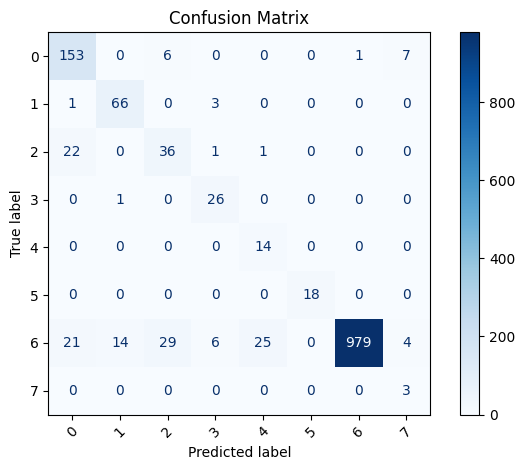

              precision    recall  f1-score   support

           0      0.777     0.916     0.841       167
           1      0.815     0.943     0.874        70
           2      0.507     0.600     0.550        60
           3      0.722     0.963     0.825        27
           4      0.350     1.000     0.519        14
           5      1.000     1.000     1.000        18
           6      0.999     0.908     0.951      1078
           7      0.214     1.000     0.353         3

    accuracy                          0.901      1437
   macro avg      0.673     0.916     0.739      1437
weighted avg      0.930     0.901     0.911      1437


 Cross-Validation Results Summary (Averaged across folds):
Accuracy       : 0.903
Macro Precision: 0.685
Macro Recall   : 0.911
Macro F1-score : 0.751


In [ ]:
# --- Constants ---
k_folds = 5
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Convert one-hot to class indices ---
y_indices = torch.argmax(y_one_hot, dim=1).numpy()

# --- Prepare Stratified K-Fold ---
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_reports = []

# --- Load Trained Model Once ---
# model = JointATTransformer(num_classes=8).to(device)
best_model_path = r"../models/best_model_checkpoint_with_class_wt_focal_loss_trans_cross_att.pth"
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# --- Store reports ---
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(y_indices)), y_indices)):
    print(f"\n Fold {fold + 1}/{k_folds}")

    val_dataset = TensorDataset(
        X_acc[val_idx], X_gyr[val_idx], X_mag[val_idx], X_mic[val_idx], y_one_hot[val_idx]
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            x_acc, x_gyr, x_mag, x_mic, labels = [b.to(device) for b in batch]
            outputs, _ = model(x_acc, x_gyr, x_mag)
            # outputs, _ = model(x_acc, x_gyr, x_mag, x_mic)
            all_preds.append(outputs.sigmoid().cpu())
            all_labels.append(labels.cpu())

    preds = torch.cat(all_preds).numpy()
    labels = torch.cat(all_labels).numpy()

    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(labels, axis=1)

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(
        y_true, y_pred, digits=3, output_dict=True, zero_division=0
    )

    # Add accuracy manually
    report["accuracy"] = {"value": acc}

    
    print(f"Fold {fold + 1} Accuracy: {acc:.3f}, Macro F1: {report['macro avg']['f1-score']:.3f}")
    fold_metrics.append(report)

# --- Aggregate Metrics ---
def aggregate_metrics(metric_list, metric_name):
    return np.mean([m[metric_name]["precision"] for m in metric_list]), \
           np.mean([m[metric_name]["recall"] for m in metric_list]), \
           np.mean([m[metric_name]["f1-score"] for m in metric_list])

macro_prec, macro_rec, macro_f1 = aggregate_metrics(fold_metrics, "macro avg")
# weighted_prec, weighted_rec, weighted_f1 = aggregate_metrics(fold_metrics, "weighted avg")
avg_acc = np.mean([m["accuracy"]["value"] for m in fold_metrics])
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
print(classification_report(y_true, y_pred, digits=3, zero_division=0))
# --- Final Summary ---
print("\n Cross-Validation Results Summary (Averaged across folds):")
print(f"Accuracy       : {avg_acc:.3f}")
print(f"Macro Precision: {macro_prec:.3f}")
print(f"Macro Recall   : {macro_rec:.3f}")
print(f"Macro F1-score : {macro_f1:.3f}")
# print(f"Weighted Precision: {weighted_prec:.3f}")
# print(f"Weighted Recall   : {weighted_rec:.3f}")
# print(f"Weighted F1-score : {weighted_f1:.3f}")

# Use macro metrics for fair, class-wise evaluation
# 🔹 Macro F1-score is the best metric for your use case.
# 🔹 It ensures small but important classes (like 3, 4, 5, 7) are not ignored.
# 🔹 Supplement with weighted metrics if needed, but don’t rely on accuracy alone.

